#Sentiment Analysis for LSTM

##Flow of program
0. Import Important Libraries
1. prepare data
2. Build LSTM model
3. Pick loss and optimizer
4. Training and Evaluation Loop
5. Start tarining loop /Visualize Model
6. Test model with new Sentence(Sentiment Analysis)

###0. Import Important Libraries

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00


In [2]:
!pip install torchtext==0.15.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 506.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=1562a25894eb202c462d860d6180c12d2b770b3c3621ab8be53f1ebefd6bfbdd
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
ERROR: pip's dependency resolver does not currently take 

In [3]:
!pip install torch  --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
import torch
import torchtext # import the installed library

print(torch.__version__)
print(torchtext.__version__)

2.0.0+cu118
0.15.0+cpu


In [5]:
import collections
import datasets
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm

###1. Prepare Data

####1.1 Loading our Dataset

In [6]:
train_data,test_data=datasets.load_dataset("imdb",split=['train','test'])

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

####1.2 Tokenize data

In [8]:
tokenizer=torchtext.data.utils.get_tokenizer("basic_english")

In [9]:
def tokenizing_input(example,tokenizer,max_length):
  tokens=tokenizer(example['text'])[:max_length]
  length=len(tokens)
  return{"tokens":tokens,"length":length}

In [10]:
max_length=256
fn_kwargs={"tokenizer":tokenizer,"max_length":max_length}

In [11]:
train_data=train_data.map(tokenizing_input,fn_kwargs=fn_kwargs)
test_data=test_data.map(tokenizing_input,fn_kwargs=fn_kwargs)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

####1.3 Creating Validation Data

In [12]:
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data['train']
valid_data=train_valid_data['test']

In [13]:
train_data,valid_data,test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'length'],
     num_rows: 18750
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'length'],
     num_rows: 6250
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'length'],
     num_rows: 25000
 }))

####1.4 Creating Vocabulary

In [14]:
min_freq=5
special_tokens=['<unk>','<pad>']
vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data['tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

In [15]:
len(vocab)

21576

In [16]:
unk_index=vocab['<unk>']
pad_index=vocab['<pad>']

In [17]:
unk_index,pad_index

(0, 1)

In [18]:
vocab.set_default_index(unk_index)

####1.5 Numericalizing Example

In [19]:
def numericalizing_input(example,vocab):
  ids=vocab.lookup_indices(example['tokens'])
  return{"ids":ids}

In [20]:
fn_kwargs={"vocab":vocab}

In [21]:
train_data=train_data.map(numericalizing_input,fn_kwargs=fn_kwargs)
valid_data=valid_data.map(numericalizing_input,fn_kwargs=fn_kwargs)
test_data=test_data.map(numericalizing_input,fn_kwargs=fn_kwargs)

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

####1.6 Create data into Tensors

In [22]:
train_data=train_data.with_format(type='torch',columns=['ids','label','length'])
test_data=test_data.with_format(type='torch',columns=['ids','label','length'])
valid_data=valid_data.with_format(type='torch',columns=['ids','label','length'])

In [23]:
train_data[0]

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  484,    23,     4,     2,   391,   127,    23,     8,     2,  3669,
          1237,    25,  2041,  2482,    24,     3,    12,   857,  1077,    11,
            27,    41,   193,  1680,     6,    12,   712,     9,    28,   111,
            14,    23,    20,  1148,   153,    22,   140,    19,    56,    19,
            11,    17,   155,   102,     3,     2,   115,    17,   358,     6,
             2,  3072,    17,    67,   414,    22,    11,   159,   985,    15,
           105,    14,    23,    25,     6,   117,    90,   168,  4682,  1634,
          5204,    98,    24,    83,     3,     2,  3987,    10,  1060,     6,
             2,   667,    10,  1033,     3,    12,    31,   128,   111,     2,
         17582,  7365,     7,  7099,    22,   130,    11,    10,     2,   178,
            23,    22,  2286,  4935,   292,  2535, 19174,    22,  2535, 19174,
            13,     0,   980,     8,     2, 17582,  7365,    10,   258,    39,


####1.7 Create Batch for data loader

In [24]:
def get_collate_fn(pad_index):
  def collate_fn(batch):
    batch_ids=[i["ids"] for i in batch]
    batch_ids=nn.utils.rnn.pad_sequence(
        batch_ids,
        padding_value=pad_index,
        batch_first=True
    )
    batch_length=[i['length'] for i in batch]
    batch_length=torch.stack(batch_length)
    batch_label=[i['label'] for i in batch]
    batch_label=torch.stack(batch_label)
    batch={"batch_ids":batch_ids,"length":batch_length,"batch_labels":batch_label}
    return batch
  return collate_fn

In [25]:
def get_batch_loader(dataset,batch_size,pad_index,shuffle=False):
  collate_fn=get_collate_fn(pad_index)
  data_loader=torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle
  )
  return data_loader

In [26]:
batch_size=512
train_batch_loader=get_batch_loader(train_data,batch_size,pad_index,shuffle=True)
valid_batch_loader=get_batch_loader(valid_data,batch_size,pad_index)
test_batch_loader=get_batch_loader(test_data,batch_size,pad_index)

In [27]:
len(train_batch_loader),len(valid_batch_loader),len(test_batch_loader)

(37, 13, 49)

###2. Bulid LSTM Model

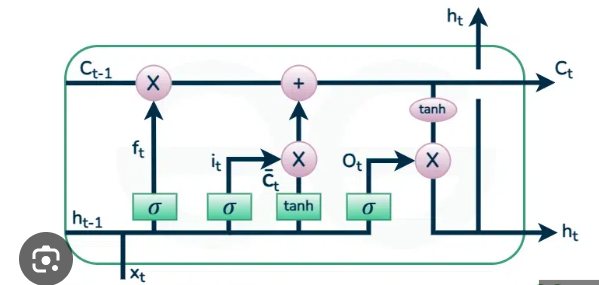



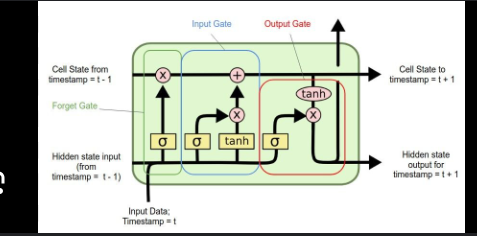

Every LSTM unfolds untill it complete the tokens in review<br>
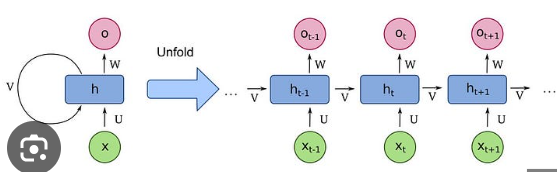

Bidirectional LSTM<br>
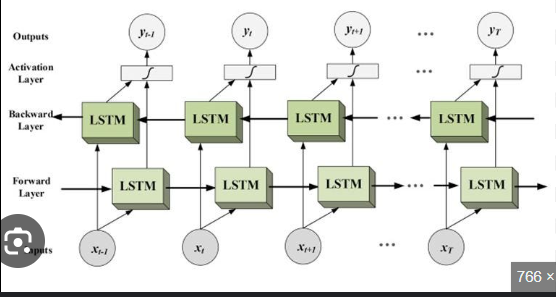

In [28]:
len(vocab)

21576

In [29]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'length', 'ids'],
    num_rows: 18750
})

In [30]:
len(train_data.unique("label"))

2

sequence a:[1,2,3]<br>
sequence b:[4,5]<br>
sequence c:[6]<br>
after padding<br>
sequence a:[1,2,3]<br>
sequence b:[4,5,0]<br>
sequence c:[6,0,0]<br>
*when it is given in the model due to extra padding computation become high*


**Packed-Sequence ?**<br>
sequence a:[1,2,3]<br>
sequence b:[4,5]<br>
sequence c:[6]<br>
**After Packed Sequence**<br>
packed_sequence=tensor[1,4,6,2,5,3]<br>

In [31]:
class LSTM(nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout_rate,pad_index):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_index)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True)
    self.fc=nn.Linear(hidden_dim*2 if bidirectional else hidden_dim,output_dim)
    self.dropout=nn.Dropout(dropout_rate)
  def forward(self,batch_ids,batch_length):
    #batch_ids=[batch_size,seq_length]
    #batch_labels=[batch_size]
    embedded=self.dropout(self.embedding(batch_ids))
    #embedded=[batch_size,seq_length,embedding_dim]
    packed_embedded=nn.utils.rnn.pack_padded_sequence(
        embedded,batch_length,batch_first=True,enforce_sorted=False
    )
    packed_output,(hidden,cell)=self.lstm(packed_embedded)
    #hidden=[n_layers*direction,batch_size,hidden_dim]
    #cell=[n_layers*direction,batch_size,hidden_dim]
    #packed_output=[n_layers*direction,batch_size,hidden_dim]
    output,output_length=nn.utils.rnn.pad_packed_sequence(packed_output)
    #output=[batch_size,hidden_dim*direction]
    if self.lstm.bidirectional:
      hidden=self.dropout(torch.cat([hidden[-1],hidden[-2]],dim=-1))
      #hidden=[batch_size,hidden_dim*2]
    else:
      hidden=self.dropout(hidden[-1])
      #hidden=[batch_size,hidden_dim]
    prediction=self.fc(hidden)
    return prediction

In [32]:
vocab_size=len(vocab)
embedding_dim=300
hidden_dim=300
n_layers=2
bidirectional=True
dropout_rate=0.5
output_dim=len(train_data.unique("label"))
model=LSTM(vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout_rate,pad_index)

In [33]:
model

LSTM(
  (embedding): Embedding(21576, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [34]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has{count_parameters(model):,} trainable parameters")

The model has10,083,602 trainable parameters


In [35]:
def initialize_weights(m):
  if isinstance(m,nn.Linear):
    nn.init.xavier_normal_(m.weight)
    nn.init.zeros_(m.bias)
  elif isinstance(m,nn.LSTM):
    for name,param in m.named_parameters():
      if 'bias' in name:
        nn.init.zeros_(param)
      elif "weight" in name:
        nn.init.orthogonal_(param)

In [36]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21576, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [37]:
vectors=torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [04:47<00:00, 7651.44it/s]


In [38]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [39]:
model.embedding.weight.data=pretrained_embedding

###3. Pick a Loss function and optimizer

In [40]:
lr =0.001

In [48]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr)

In [49]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
model=model.to(device)
criterion=criterion.to(device)

###4. Training And Evaluate Functions

In [51]:
def train(batch_loader,model,criterion,optimizer,device):
  model.train()
  epoch_loss=[]
  epoch_acc=[]
  for batch in tqdm.tqdm(batch_loader,desc="training...."):
      batch_ids=batch['batch_ids'].to(device)
      length=batch['length']
      batch_labels=batch['batch_labels'].to(device)
      # batch_labels = batch_labels.unsqueeze(1).float()
      predictions=model(batch_ids,length)
      loss=criterion(predictions,batch_labels)
      accuracy=get_accuracy(predictions,batch_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss.append(loss.item())
      epoch_acc.append(accuracy.item())
  return np.mean(epoch_loss),np.mean(epoch_acc)

In [52]:
def evaluate(batch_loader,model,criterion,device):
  model.eval()
  epoch_loss=[]
  epoch_acc=[]
  with torch.no_grad():
    for batch in tqdm.tqdm(batch_loader,desc="evaluating...."):
      batch_ids=batch['batch_ids'].to(device)
      length=batch['length']
      batch_labels=batch['batch_labels'].to(device)
      # batch_labels = batch_labels.unsqueeze(1).float()
      predictions=model(batch_ids,length)
      loss=criterion(predictions,batch_labels)
      accuracy=get_accuracy(predictions,batch_labels)
      epoch_loss.append(loss.item())
      epoch_acc.append(accuracy.item())
  return np.mean(epoch_loss),np.mean(epoch_acc)

In [53]:
def get_accuracy(predictions,batch_labels):
  batch_size,_=predictions.shape
  predicted_class=predictions.argmax(dim=-1)
  correct_predictions = predicted_class.eq(batch_labels).sum()
  accuracy=correct_predictions/batch_size
  return accuracy

###5. Start Training Loop

**visulaising training loss and validation loss**

In [54]:
n_epochs=3
best_valid_loss=float("inf")

metrics=collections.defaultdict(list)

for epoch in range(n_epochs):
  train_loss,train_acc=train(train_batch_loader,model,criterion,optimizer,device)
  valid_loss,valid_acc=evaluate(valid_batch_loader,model,criterion,device)
  metrics["train_loss"].append(train_loss)
  metrics["train_acc"].append(train_acc)
  metrics["valid_loss"].append(valid_loss)
  metrics["valid_acc"].append(valid_acc)
  if valid_loss < best_valid_loss:
    best_valid_loss=best_valid_loss
    torch.save(model.state_dict(),'./LSTM.pt')
  print(f"epoch:{epoch}")
  print(f"train_loss:{train_loss:.3f},train_acc:{train_acc:.3f}")
  print(f"valid_loss:{valid_loss:.3f},valid_acc:{valid_acc:.3f}")

evaluating....: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


epoch:0
train_loss:0.599,train_acc:0.660
valid_loss:0.642,valid_acc:0.586


evaluating....: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


epoch:1
train_loss:0.654,train_acc:0.617
valid_loss:0.618,valid_acc:0.675


evaluating....: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

epoch:2
train_loss:0.588,train_acc:0.698
valid_loss:0.604,valid_acc:0.660


###6. Visualize your model

In [55]:
import matplotlib.pyplot as plt

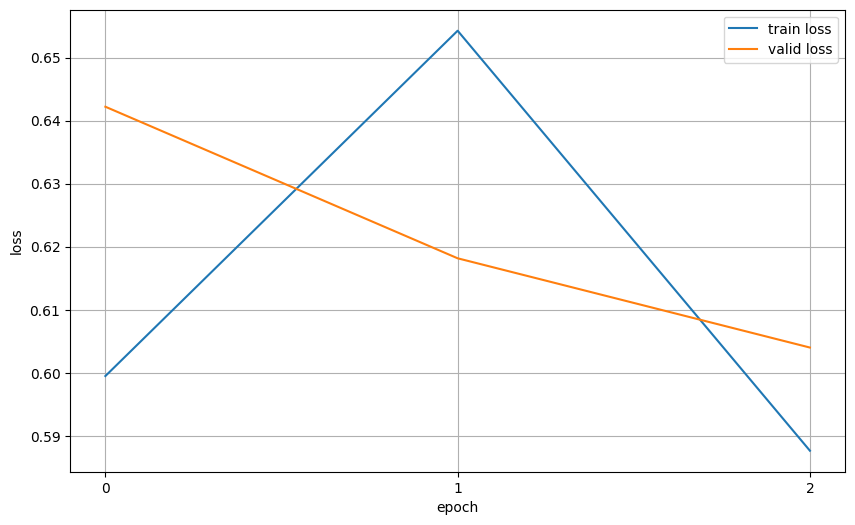

In [58]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics["train_loss"],label='train loss')
ax.plot(metrics["valid_loss"],label='valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

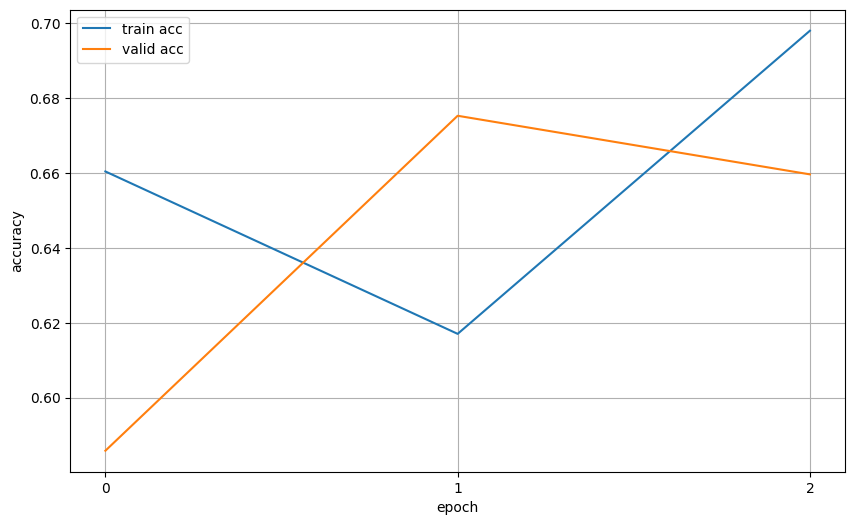

In [60]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics["train_acc"],label='train acc')
ax.plot(metrics["valid_acc"],label='valid acc')
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

####Again Loading state_dict()

In [61]:
model.state_dict(torch.load("LSTM.pt"))
test_loss,test_acc=evaluate(test_batch_loader,model,criterion,device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
evaluating....: 100%|██████████| 49/49 [00:12<00:00,  3.80it/s]


In [62]:
print(f"The test loss:{test_loss} and test accurcay:{test_acc}")

The test loss:0.6069630907506359 and test accurcay:0.6491008254946494


###7. Testing Model with New sentences(Sentiment Analysis)

In [66]:
def predict_sentiment(text,model,tokenizer,vocab,device):
    tokens=tokenizer(text)
    ids=vocab.lookup_indices(tokens)
    length=torch.LongTensor([len(ids)])
    tensor=torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction=model(tensor,length).squeeze(dim=0)
    probability=torch.softmax(prediction,dim=-1)
    predicted_class=prediction.argmax(dim=-1).item()
    predicted_probability=probability[predicted_class].item()
    return predicted_class,predicted_probability

In [67]:
text="this movie is great"
predict_sentiment(text,model,tokenizer,vocab,device)

(1, 0.8202028274536133)

In [68]:
text="this movie is terrible"
predict_sentiment(text,model,tokenizer,vocab,device)

(0, 0.850705623626709)